In [1]:
from pennylane import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt

In [2]:
'''
Here we are gonna use Amplitude damping and Phase damping noise
'''

'\nHere we are gonna use Amplitude damping and Phase damping noise\n'

In [3]:
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0,-1j],[1j, 0]])

In [4]:
'''
T1 = single-qubit (energy) relaxation time and 
T2 = dephasing time
'''

'\nT1 = single-qubit (energy) relaxation time and \nT2 = dephasing time\n'

In [5]:
t=np.linspace(1,200,200)*10**(-9)#60*10**(-9)
T1=400*10**(-9)
T2=200*10**(-9)
steps=4

In [6]:
#P_AD=0
#P_PD=0
def P(t,T1,T2):
    
    P_AD=1-np.exp(-t/T1)
    P_PD=1-np.exp(-t*2/T2)*np.exp(t/T1)
    
    return P_AD,P_PD

In [7]:
def ED(t,T1,T2):
    P_AD,P_PD=P(t,T1,T2)
    gamma=P_AD
    Lambda=(1-P_AD)*P_PD
    
    ED1=((1+np.sqrt(1-gamma-Lambda))/2)*I+((1-np.sqrt(1-gamma-Lambda))/2)*Z
    ED2=np.sqrt(gamma)/2*X+1j*np.sqrt(gamma)/2*Y
    ED3=np.sqrt(Lambda)/2*I-np.sqrt(Lambda)/2*Z
    
    return ED1,ED2,ED3

In [8]:
a,b,c=ED(0.1,0.008,0.005)
c

tensor([[0.        , 0.        ],
        [0.        , 0.00193045]], requires_grad=True)

In [9]:
dev=qml.device("default.mixed",wires=3)

In [10]:
@qml.qnode(dev)
def density_matrix(step):
   
    if step==0:
        qml.BasisState([1,1,1], wires=[0,1,2])
        return qml.state()
    if step==1:
        qml.BasisState([1,1,1], wires=[0,1,2])
        qml.Hadamard(wires=0)
        return qml.state()
    
    if step==2:
        qml.BasisState([1,1,1], wires=[0,1,2])
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0,1])
        return qml.state()
    
    if step==3:
        qml.BasisState([1,1,1], wires=[0,1,2])
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[0,2])
        return qml.state()
    
    
    if step==4:
        qml.BasisState([1,1,1], wires=[0,1,2])
        qml.Hadamard(wires=0)
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[0,2])
        qml.Hadamard(wires=0)
        return qml.state()

In [11]:
density_matrix(0)

tensor([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]], requires_grad=False)

In [12]:
# Function to find the fidelity between two density matrix
def Fidelity(rho1,rho2):
    if rho1.shape!=rho2.shape:
        raise ValueError("Dimension of both matrices must be same")
    return ((np.trace(np.dot(np.transpose(np.conj(rho1)),rho2))))  # as one of them is pure (entangled) state

In [13]:
def Decoherent_state_0( t,  T1,  T2,  steps):
    
    #rho=ρ_noise
    rho=density_matrix(steps)
    
    ED1,ED2,ED3=ED(t,T1,T2)
    
    Kraus_on_1_ED1=np.kron(np.kron(ED1,I),I)
    Kraus_on_1_ED2=np.kron(np.kron(ED2,I),I)
    Kraus_on_1_ED3=np.kron(np.kron(ED3,I),I)
    
    epsilon_D_rho_1=np.dot(np.dot(Kraus_on_1_ED1,rho),np.transpose(np.conj(Kraus_on_1_ED1)))+\
                    np.dot(np.dot(Kraus_on_1_ED2,rho),np.transpose(np.conj(Kraus_on_1_ED2)))+\
                    np.dot(np.dot(Kraus_on_1_ED3,rho),np.transpose(np.conj(Kraus_on_1_ED3)))
    
    # for rho1 only hadamard is applied to 1st qubit thus noise should also be applied to 1st but can be applied to qubits
    # in both the cases the result will be the same
    
    Kraus_on_2_ED1=np.kron(np.kron(I,ED1),I)
    Kraus_on_2_ED2=np.kron(np.kron(I,ED2),I)
    Kraus_on_2_ED3=np.kron(np.kron(I,ED3),I)
    
    epsilon_D_rho_2=np.dot(np.dot(Kraus_on_2_ED1,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED1)))+\
                    np.dot(np.dot(Kraus_on_2_ED2,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED2)))+\
                    np.dot(np.dot(Kraus_on_2_ED3,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED3)))
    
    Kraus_on_3_ED1=np.kron(np.kron(I,I),ED1)
    Kraus_on_3_ED2=np.kron(np.kron(I,I),ED2)
    Kraus_on_3_ED3=np.kron(np.kron(I,I),ED3)
    
    epsilon_D_rho_3=np.dot(np.dot(Kraus_on_3_ED1,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED1)))+\
                    np.dot(np.dot(Kraus_on_3_ED2,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED2)))+\
                    np.dot(np.dot(Kraus_on_3_ED3,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED3)))
    '''
    return epsilon_D_rho_3
    '''
    return epsilon_D_rho_3
    

In [14]:
ρ_noise_0=[]
ρ_noise_0=[Decoherent_state_0(time,T1,T2,0) for time in t] 
len(ρ_noise_0)

200

In [15]:
rho2=density_matrix(0)  # this is the pure density matrix 
F_0=[]
for rho1 in ρ_noise_0:
    F_0.append(Fidelity(rho1,rho2))
    
len(F_0)

200

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


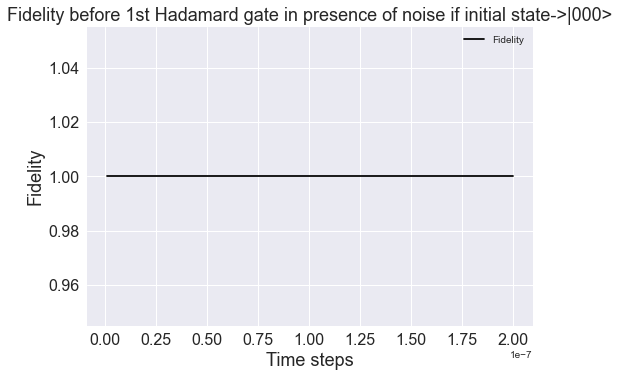

In [22]:
plt.style.use("seaborn")
plt.plot(t,F_0,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity before 1st Hadamard gate in presence of noise if initial state->|000>", fontsize=18)
plt.legend()
plt.show()

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


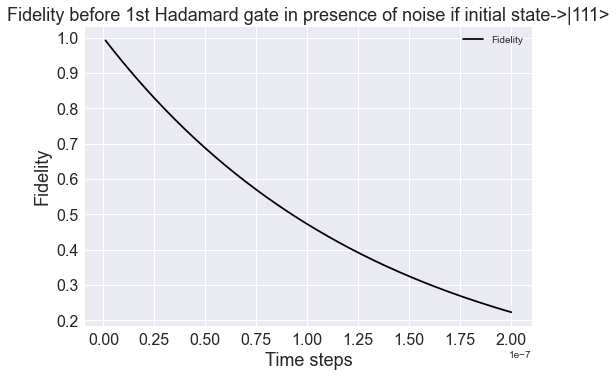

In [16]:
plt.style.use("seaborn")
plt.plot(t,F_0,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity before 1st Hadamard gate in presence of noise if initial state->|111>", fontsize=18)
plt.legend()
plt.show()

In [17]:
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi

In the below six cells we are calculating the reduced density matrices: 1st 3-> all possible 1 qubit states and last 3-> all possible 2 qubit states

In [18]:
rho_A1 = []
for r in ρ_noise_0:
    rho_A1.append(qi.partial_trace(r,[1,2]))
    
print(len(rho_A1))
rho_A1[0]

200
DensityMatrix([[0.00249688+0.j, 0.        +0.j],
               [0.        +0.j, 0.99750312+0.j]],
              dims=(2,))


In [19]:
rho_B1 = []
for r in ρ_noise_0:
    rho_B1.append(qi.partial_trace(r,[0,2]))
    
print(len(rho_B1))
rho_B1[0]

200
DensityMatrix([[0.00249688+0.j, 0.        +0.j],
               [0.        +0.j, 0.99750312+0.j]],
              dims=(2,))


In [20]:
rho_C1 = []
for r in ρ_noise_0:
    rho_C1.append(qi.partial_trace(r,[0,1]))
    
print(len(rho_C1))
rho_C1[0]

200
DensityMatrix([[0.00249688+0.j, 0.        +0.j],
               [0.        +0.j, 0.99750312+0.j]],
              dims=(2,))


In [24]:
# Two qubit reduced dencity matrix

In [21]:
rho_D12 = []
for r in ρ_noise_0:
    rho_D12.append(qi.partial_trace(r,[2]))
    
print(len(rho_D12))
rho_D12[0]

200
DensityMatrix([[6.23439776e-06+0.j, 0.00000000e+00+0.j,
                0.00000000e+00+0.j, 0.00000000e+00+0.j],
               [0.00000000e+00+0.j, 2.49064320e-03+0.j,
                0.00000000e+00+0.j, 0.00000000e+00+0.j],
               [0.00000000e+00+0.j, 0.00000000e+00+0.j,
                2.49064320e-03+0.j, 0.00000000e+00+0.j],
               [0.00000000e+00+0.j, 0.00000000e+00+0.j,
                0.00000000e+00+0.j, 9.95012479e-01+0.j]],
              dims=(2, 2))


In [22]:
rho_D23 = []
for r in ρ_noise_0:
    rho_D23.append(qi.partial_trace(r,[0]))
    
print(len(rho_D23))
rho_D23[0]

200
DensityMatrix([[6.23439776e-06+0.j, 0.00000000e+00+0.j,
                0.00000000e+00+0.j, 0.00000000e+00+0.j],
               [0.00000000e+00+0.j, 2.49064320e-03+0.j,
                0.00000000e+00+0.j, 0.00000000e+00+0.j],
               [0.00000000e+00+0.j, 0.00000000e+00+0.j,
                2.49064320e-03+0.j, 0.00000000e+00+0.j],
               [0.00000000e+00+0.j, 0.00000000e+00+0.j,
                0.00000000e+00+0.j, 9.95012479e-01+0.j]],
              dims=(2, 2))


In [25]:
rho_D13 = []
for r in ρ_noise_0:
    rho_D13.append(qi.partial_trace(r,[1]))
    
print(len(rho_D13))
rho_D13[0]

200
DensityMatrix([[6.23439776e-06+0.j, 0.00000000e+00+0.j,
                0.00000000e+00+0.j, 0.00000000e+00+0.j],
               [0.00000000e+00+0.j, 2.49064320e-03+0.j,
                0.00000000e+00+0.j, 0.00000000e+00+0.j],
               [0.00000000e+00+0.j, 0.00000000e+00+0.j,
                2.49064320e-03+0.j, 0.00000000e+00+0.j],
               [0.00000000e+00+0.j, 0.00000000e+00+0.j,
                0.00000000e+00+0.j, 9.95012479e-01+0.j]],
              dims=(2, 2))


In [26]:
H=1/np.sqrt(2)*np.array([[1,1],[1,-1]])

In [27]:
def Decoherent_state_1( t,  T1,  T2, density_matrix):
    
    #rho=ρ_noise
    rho=density_matrix
    
    rho=np.dot(np.dot(np.kron(np.kron(H,I),I),rho),np.transpose(np.conj(np.kron(np.kron(H,I),I))))
    
    ED1,ED2,ED3=ED(t,T1,T2)
    
    Kraus_on_1_ED1=np.kron(np.kron(ED1,I),I)
    Kraus_on_1_ED2=np.kron(np.kron(ED2,I),I)
    Kraus_on_1_ED3=np.kron(np.kron(ED3,I),I)
    
    epsilon_D_rho_1=np.dot(np.dot(Kraus_on_1_ED1,rho),np.transpose(np.conj(Kraus_on_1_ED1)))+\
                    np.dot(np.dot(Kraus_on_1_ED2,rho),np.transpose(np.conj(Kraus_on_1_ED2)))+\
                    np.dot(np.dot(Kraus_on_1_ED3,rho),np.transpose(np.conj(Kraus_on_1_ED3)))
    
    # for rho1 only hadamard is applied to 1st qubit thus noise should also be applied to 1st but can be applied to qubits
    # in both the cases the result will be the same
    
    Kraus_on_2_ED1=np.kron(np.kron(I,ED1),I)
    Kraus_on_2_ED2=np.kron(np.kron(I,ED2),I)
    Kraus_on_2_ED3=np.kron(np.kron(I,ED3),I)
    
    epsilon_D_rho_2=np.dot(np.dot(Kraus_on_2_ED1,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED1)))+\
                    np.dot(np.dot(Kraus_on_2_ED2,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED2)))+\
                    np.dot(np.dot(Kraus_on_2_ED3,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED3)))
    
    Kraus_on_3_ED1=np.kron(np.kron(I,I),ED1)
    Kraus_on_3_ED2=np.kron(np.kron(I,I),ED2)
    Kraus_on_3_ED3=np.kron(np.kron(I,I),ED3)
    
    epsilon_D_rho_3=np.dot(np.dot(Kraus_on_3_ED1,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED1)))+\
                    np.dot(np.dot(Kraus_on_3_ED2,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED2)))+\
                    np.dot(np.dot(Kraus_on_3_ED3,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED3)))
    
    return epsilon_D_rho_3

In [28]:
ρ_noise=[]
ρ_noise=[Decoherent_state_1(time,T1,T2,density_matrix) for time,density_matrix in zip(t,ρ_noise_0)] 
len(ρ_noise)

200

In [29]:
rho2=density_matrix(1)  # this is the pure density matrix 
F=[]
for rho1 in ρ_noise:
    F.append(Fidelity(rho1,rho2))
    
len(F)

200

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


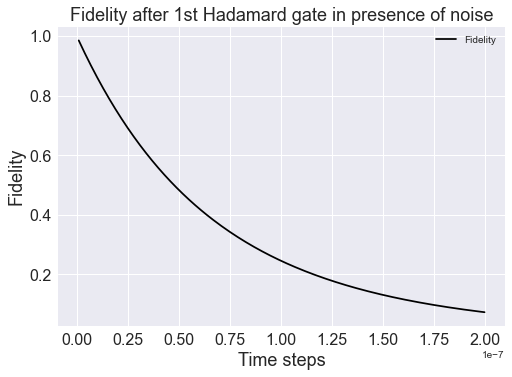

In [30]:
plt.style.use("seaborn")
plt.plot(t,F,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity after 1st Hadamard gate in presence of noise", fontsize=18)
plt.legend()
plt.show()

In [31]:
rho_A2 = []
for r in ρ_noise:
    rho_A2.append(qi.partial_trace(r,[1,2]))
    
print(len(rho_A2))
rho_A2[0]

200
DensityMatrix([[0.00498752+0.j, 0.        +0.j],
               [0.        +0.j, 0.99501248+0.j]],
              dims=(2,))


In [32]:
rho_B2 = []
for r in ρ_noise:
    rho_B2.append(qi.partial_trace(r,[0,2]))
    
print(len(rho_B2))
rho_B2[0]

200
DensityMatrix([[0.00498752+0.j, 0.        +0.j],
               [0.        +0.j, 0.99501248+0.j]],
              dims=(2,))


In [33]:
rho_C2 = []
for r in ρ_noise:
    rho_C2.append(qi.partial_trace(r,[0,1]))
    
print(len(rho_C2))
rho_C2[0]

200
DensityMatrix([[ 0.50124844+0.j, -0.49502182+0.j],
               [-0.49502182+0.j,  0.49875156+0.j]],
              dims=(2,))


In [34]:
rho_E12 = []
for r in ρ_noise:
    rho_E12.append(qi.partial_trace(r,[2]))
    
print(len(rho_E12))
rho_E12[0]

200
DensityMatrix([[2.48753638e-05+0.j, 0.00000000e+00+0.j,
                0.00000000e+00+0.j, 0.00000000e+00+0.j],
               [0.00000000e+00+0.j, 4.96264544e-03+0.j,
                0.00000000e+00+0.j, 0.00000000e+00+0.j],
               [0.00000000e+00+0.j, 0.00000000e+00+0.j,
                4.96264544e-03+0.j, 0.00000000e+00+0.j],
               [0.00000000e+00+0.j, 0.00000000e+00+0.j,
                0.00000000e+00+0.j, 9.90049834e-01+0.j]],
              dims=(2, 2))


In [35]:
rho_E23 = []
for r in ρ_noise:
    rho_E23.append(qi.partial_trace(r,[0]))
    
print(len(rho_E23))
rho_E23[0]

200
DensityMatrix([[ 0.00249999+0.j,  0.        +0.j, -0.00246893+0.j,
                 0.        +0.j],
               [ 0.        +0.j,  0.49874845+0.j,  0.        +0.j,
                -0.49255288+0.j],
               [-0.00246893+0.j,  0.        +0.j,  0.00248753+0.j,
                 0.        +0.j],
               [ 0.        +0.j, -0.49255288+0.j,  0.        +0.j,
                 0.49626403+0.j]],
              dims=(2, 2))


In [36]:
rho_E13 = []
for r in ρ_noise:
    rho_E13.append(qi.partial_trace(r,[1]))
    
print(len(rho_E13))
rho_E13[0]

200
DensityMatrix([[ 0.00249999+0.j,  0.        +0.j, -0.00246893+0.j,
                 0.        +0.j],
               [ 0.        +0.j,  0.49874845+0.j,  0.        +0.j,
                -0.49255288+0.j],
               [-0.00246893+0.j,  0.        +0.j,  0.00248753+0.j,
                 0.        +0.j],
               [ 0.        +0.j, -0.49255288+0.j,  0.        +0.j,
                 0.49626403+0.j]],
              dims=(2, 2))


In [37]:
cnot=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

In [38]:
def Decoherent_state_2( t,  T1,  T2,  density_matrix):
    
    #rho=ρ_noise
    rho=density_matrix
    
    rho=np.dot(np.dot(np.kron(cnot,I),rho),np.kron(cnot,I)) # applying 1st CNOT to qubits=[0,1]
    
    ED1,ED2,ED3=ED(t,T1,T2)
    
    Kraus_on_1_ED1=np.kron(np.kron(ED1,I),I)
    Kraus_on_1_ED2=np.kron(np.kron(ED2,I),I)
    Kraus_on_1_ED3=np.kron(np.kron(ED3,I),I)
    
    epsilon_D_rho_1=np.dot(np.dot(Kraus_on_1_ED1,rho),np.transpose(np.conj(Kraus_on_1_ED1)))+\
                    np.dot(np.dot(Kraus_on_1_ED2,rho),np.transpose(np.conj(Kraus_on_1_ED2)))+\
                    np.dot(np.dot(Kraus_on_1_ED3,rho),np.transpose(np.conj(Kraus_on_1_ED3)))
    
    # for rho1 only hadamard is applied to 1st qubit thus noise should also be applied to 1st but can be applied to qubits
    # in both the cases the result will be the same
    
    
    #epsilon_D_rho_1=np.dot(np.dot(np.kron(cnot,I),epsilon_D_rho_1),np.kron(cnot,I)) # applying 1st CNOT to qubits=[0,1]
    
    Kraus_on_2_ED1=np.kron(np.kron(I,ED1),I)
    Kraus_on_2_ED2=np.kron(np.kron(I,ED2),I)
    Kraus_on_2_ED3=np.kron(np.kron(I,ED3),I)
    
    epsilon_D_rho_2=np.dot(np.dot(Kraus_on_2_ED1,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED1)))+\
                    np.dot(np.dot(Kraus_on_2_ED2,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED2)))+\
                    np.dot(np.dot(Kraus_on_2_ED3,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED3)))
    
    Kraus_on_3_ED1=np.kron(np.kron(I,I),ED1)
    Kraus_on_3_ED2=np.kron(np.kron(I,I),ED2)
    Kraus_on_3_ED3=np.kron(np.kron(I,I),ED3)
    
    epsilon_D_rho_3=np.dot(np.dot(Kraus_on_3_ED1,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED1)))+\
                    np.dot(np.dot(Kraus_on_3_ED2,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED2)))+\
                    np.dot(np.dot(Kraus_on_3_ED3,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED3)))
    
    return epsilon_D_rho_3
    
    

In [39]:
ρ_noise2=[]
ρ_noise2=[Decoherent_state_2(time,T1,T2,density_matrix) for time,density_matrix in zip(t,ρ_noise)] 
len(ρ_noise2)

200

In [40]:
rho2=density_matrix(2)  # this is the pure density matrix 
F2=[]
for rho1 in ρ_noise2:
    F2.append(Fidelity(rho1,rho2))
    

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


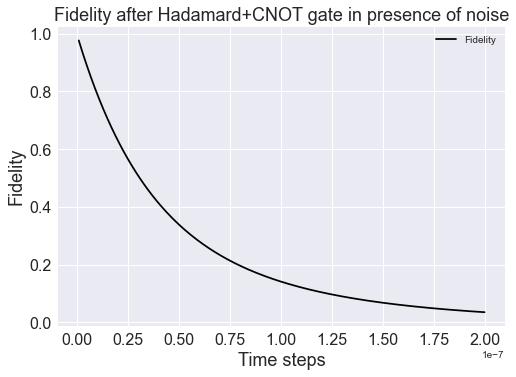

In [41]:
plt.style.use("seaborn")
plt.plot(t,F2,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity after Hadamard+CNOT gate in presence of noise", fontsize=18)
plt.legend()
plt.show()

In [62]:
rho_A3 = []
for r in ρ_noise2:
    rho_A3.append(qi.partial_trace(r,[1,2]))
    
print(len(rho_A3))
rho_A3[0]

200
DensityMatrix([[0.00747195+0.j, 0.        +0.j],
               [0.        +0.j, 0.99252805+0.j]],
              dims=(2,))


In [84]:
rho_B3 = []
for r in ρ_noise2:
    rho_B3.append(qi.partial_trace(r,[0,2]))
    
print(len(rho_B3))
rho_B3[0]

200
DensityMatrix([[0.50001554+0.j, 0.        +0.j],
               [0.        +0.j, 0.49998446+0.j]],
              dims=(2,))


In [88]:
rho_C3 = []
for r in ρ_noise2:
    rho_C3.append(qi.partial_trace(r,[0,1]))
    
print(len(rho_C3))
rho_C3[0]

200
DensityMatrix([[0.50249376+0.j, 0.        +0.j],
               [0.        +0.j, 0.49750624+0.j]],
              dims=(2,))


In [42]:
rho_F12 = []
for r in ρ_noise2:
    rho_F12.append(qi.partial_trace(r,[2]))
    
print(len(rho_F12))
rho_F12[0]

200
DensityMatrix([[0.00373609+0.j, 0.        +0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.49627945+0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.00373586+0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.        +0.j,
                0.4962486 +0.j]],
              dims=(2, 2))


In [43]:
rho_F23 = []
for r in ρ_noise2:
    rho_F23.append(qi.partial_trace(r,[0]))
    
print(len(rho_F23))
rho_F23[0]

200
DensityMatrix([[ 0.00498443+0.j,  0.        +0.j,  0.        +0.j,
                -0.00244437+0.j],
               [ 0.        +0.j,  0.49750933+0.j, -0.4876519 +0.j,
                 0.        +0.j],
               [ 0.        +0.j, -0.4876519 +0.j,  0.49503111+0.j,
                 0.        +0.j],
               [-0.00244437+0.j,  0.        +0.j,  0.        +0.j,
                 0.00247513+0.j]],
              dims=(2, 2))


In [44]:
rho_F13 = []
for r in ρ_noise2:
    rho_F13.append(qi.partial_trace(r,[1]))
    
print(len(rho_F13))
rho_F13[0]

200
DensityMatrix([[0.00375461+0.j, 0.        +0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.49873915+0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.00371734+0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.        +0.j,
                0.4937889 +0.j]],
              dims=(2, 2))


In [45]:
cnot_0_2=np.array([[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,0,0,1],[0,0,0,0,0,0,1,0]])
cnot_0_2

tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0]], requires_grad=True)

In [46]:
def Decoherent_state_3( t,  T1,  T2,  density_matrix):
    
    #rho=ρ_noise
    rho=density_matrix
    
    rho=np.dot(np.dot(cnot_0_2,rho),cnot_0_2) # applying 1st CNOT to qubits=[0,1]

    ED1,ED2,ED3=ED(t,T1,T2)
    
    Kraus_on_1_ED1=np.kron(np.kron(ED1,I),I)
    Kraus_on_1_ED2=np.kron(np.kron(ED2,I),I)
    Kraus_on_1_ED3=np.kron(np.kron(ED3,I),I)
    
    epsilon_D_rho_1=np.dot(np.dot(Kraus_on_1_ED1,rho),np.transpose(np.conj(Kraus_on_1_ED1)))+\
                    np.dot(np.dot(Kraus_on_1_ED2,rho),np.transpose(np.conj(Kraus_on_1_ED2)))+\
                    np.dot(np.dot(Kraus_on_1_ED3,rho),np.transpose(np.conj(Kraus_on_1_ED3)))
    
    #epsilon_D_rho_1=np.dot(np.dot(np.kron(cnot,I),epsilon_D_rho_1),np.kron(cnot,I)) # applying 1st CNOT to qubits=[0,1]
    
    Kraus_on_2_ED1=np.kron(np.kron(I,ED1),I)
    Kraus_on_2_ED2=np.kron(np.kron(I,ED2),I)
    Kraus_on_2_ED3=np.kron(np.kron(I,ED3),I)
    
    epsilon_D_rho_2=np.dot(np.dot(Kraus_on_2_ED1,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED1)))+\
                    np.dot(np.dot(Kraus_on_2_ED2,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED2)))+\
                    np.dot(np.dot(Kraus_on_2_ED3,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED3)))
    
    Kraus_on_3_ED1=np.kron(np.kron(I,I),ED1)
    Kraus_on_3_ED2=np.kron(np.kron(I,I),ED2)
    Kraus_on_3_ED3=np.kron(np.kron(I,I),ED3)
    
    epsilon_D_rho_3=np.dot(np.dot(Kraus_on_3_ED1,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED1)))+\
                    np.dot(np.dot(Kraus_on_3_ED2,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED2)))+\
                    np.dot(np.dot(Kraus_on_3_ED3,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED3)))
    
    return epsilon_D_rho_3

    

In [47]:
ρ_noise3=[]
ρ_noise3=[Decoherent_state_3(time,T1,T2,density_matrix) for time,density_matrix in zip(t,ρ_noise2)] 
len(ρ_noise3)

200

In [48]:
rho2=density_matrix(3)  # this is the pure density matrix 
F3=[]
for rho1 in ρ_noise3:
    F3.append(Fidelity(rho1,rho2))
    

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


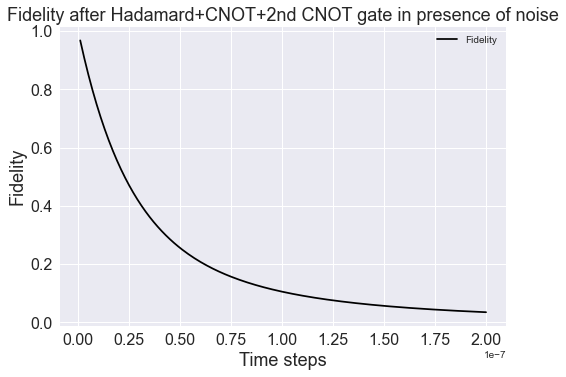

In [49]:
plt.style.use("seaborn")
plt.plot(t,F3,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity after Hadamard+CNOT+2nd CNOT gate in presence of noise", fontsize=18)
plt.legend()
plt.show()

In [68]:
rho_A4 = []
for r in ρ_noise3:
    rho_A4.append(qi.partial_trace(r,[1,2]))
    
print(len(rho_A4))
rho_A4[0]

200
DensityMatrix([[0.49879808+0.j, 0.        +0.j],
               [0.        +0.j, 0.50120192+0.j]],
              dims=(2,))


In [90]:
rho_B4 = []
for r in ρ_noise3:
    rho_B4.append(qi.partial_trace(r,[0,2]))
    
print(len(rho_B4))
rho_B4[0]

200
DensityMatrix([[0.50126394+0.j, 0.        +0.j],
               [0.        +0.j, 0.49873606+0.j]],
              dims=(2,))


In [91]:
rho_C4 = []
for r in ρ_noise3:
    rho_C4.append(qi.partial_trace(r,[0,1]))
    
print(len(rho_C4))
rho_C4[0]

200
DensityMatrix([[0.50373597+0.j, 0.        +0.j],
               [0.        +0.j, 0.49626403+0.j]],
              dims=(2,))


In [50]:
rho_G12 = []
for r in ρ_noise3:
    rho_G12.append(qi.partial_trace(r,[2]))
    
print(len(rho_G12))
rho_G12[0]

200
DensityMatrix([[0.49140959+0.j, 0.        +0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.00985435+0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.00738849+0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.        +0.j,
                0.49134758+0.j]],
              dims=(2, 2))


In [51]:
rho_G23 = []
for r in ρ_noise3:
    rho_G23.append(qi.partial_trace(r,[0]))
    
print(len(rho_G23))
rho_G23[0]

200
DensityMatrix([[0.00746269+0.j, 0.        +0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.49627328+0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.49380124+0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.        +0.j,
                0.00246278+0.j]],
              dims=(2, 2))


In [52]:
rho_G13 = []
for r in ρ_noise3:
    rho_G13.append(qi.partial_trace(r,[1]))
    
print(len(rho_G13))
rho_G13[0]

200
DensityMatrix([[0.00623285+0.j, 0.        +0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.49750312+0.j, 0.        +0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.49256523+0.j,
                0.        +0.j],
               [0.        +0.j, 0.        +0.j, 0.        +0.j,
                0.0036988 +0.j]],
              dims=(2, 2))


In [53]:
H=1/np.sqrt(2)*np.array([[1,1],[1,-1]])

In [54]:
def Decoherent_state_4( t,  T1,  T2, density_matrix):
    
    #rho=ρ_noise
    rho=density_matrix
    
    rho=np.dot(np.dot(np.kron(np.kron(H,I),I),rho),np.transpose(np.conj(np.kron(np.kron(H,I),I))))
    
    ED1,ED2,ED3=ED(t,T1,T2)
    
    Kraus_on_1_ED1=np.kron(np.kron(ED1,I),I)
    Kraus_on_1_ED2=np.kron(np.kron(ED2,I),I)
    Kraus_on_1_ED3=np.kron(np.kron(ED3,I),I)
    
    epsilon_D_rho_1=np.dot(np.dot(Kraus_on_1_ED1,rho),np.transpose(np.conj(Kraus_on_1_ED1)))+\
                    np.dot(np.dot(Kraus_on_1_ED2,rho),np.transpose(np.conj(Kraus_on_1_ED2)))+\
                    np.dot(np.dot(Kraus_on_1_ED3,rho),np.transpose(np.conj(Kraus_on_1_ED3)))
    
    # for rho1 only hadamard is applied to 1st qubit thus noise should also be applied to 1st but can be applied to qubits
    # in both the cases the result will be the same
    
    Kraus_on_2_ED1=np.kron(np.kron(I,ED1),I)
    Kraus_on_2_ED2=np.kron(np.kron(I,ED2),I)
    Kraus_on_2_ED3=np.kron(np.kron(I,ED3),I)
    
    epsilon_D_rho_2=np.dot(np.dot(Kraus_on_2_ED1,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED1)))+\
                    np.dot(np.dot(Kraus_on_2_ED2,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED2)))+\
                    np.dot(np.dot(Kraus_on_2_ED3,epsilon_D_rho_1),np.transpose(np.conj(Kraus_on_2_ED3)))
    
    Kraus_on_3_ED1=np.kron(np.kron(I,I),ED1)
    Kraus_on_3_ED2=np.kron(np.kron(I,I),ED2)
    Kraus_on_3_ED3=np.kron(np.kron(I,I),ED3)
    
    epsilon_D_rho_3=np.dot(np.dot(Kraus_on_3_ED1,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED1)))+\
                    np.dot(np.dot(Kraus_on_3_ED2,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED2)))+\
                    np.dot(np.dot(Kraus_on_3_ED3,epsilon_D_rho_2),np.transpose(np.conj(Kraus_on_3_ED3)))
    
    return epsilon_D_rho_3

In [55]:
ρ_noise4=[]
ρ_noise4=[Decoherent_state_4(time,T1,T2,density_matrix) for time,density_matrix in zip(t,ρ_noise3)] 
len(ρ_noise4)

200

In [56]:
rho2=density_matrix(4)  # this is the pure density matrix 
F4=[]
for rho1 in ρ_noise4:
    F4.append(Fidelity(rho1,rho2))
    

C:\Users\Arunava\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


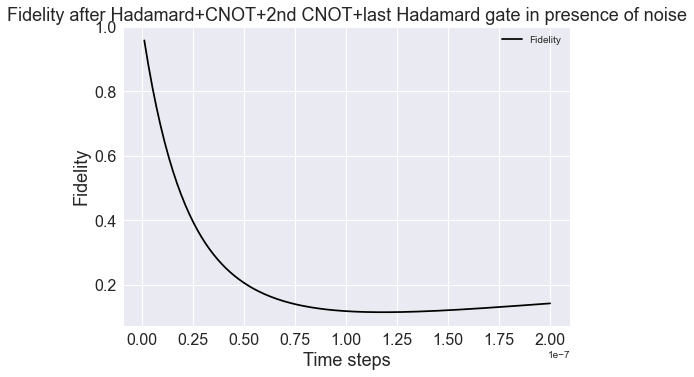

In [57]:
plt.style.use("seaborn")
plt.plot(t,F4,"black",label="Fidelity")
plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Time steps", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Fidelity after Hadamard+CNOT+2nd CNOT+last Hadamard gate in presence of noise", fontsize=18)
plt.legend()
plt.show()

In [75]:
rho_A5 = []
for r in ρ_noise4:
    rho_A5.append(qi.partial_trace(r,[1,2]))
    
print(len(rho_A5))
rho_A5[14]

200
DensityMatrix([[0.50974326+0.j, 0.        +0.j],
               [0.        +0.j, 0.49025674+0.j]],
              dims=(2,))


In [92]:
rho_B5 = []
for r in ρ_noise4:
    rho_B5.append(qi.partial_trace(r,[0,2]))
    
print(len(rho_B5))
rho_B5[14]

200
DensityMatrix([[0.53913311+0.j, 0.        +0.j],
               [0.        +0.j, 0.46086689+0.j]],
              dims=(2,))


In [93]:
rho_C5 = []
for r in ρ_noise4:
    rho_C5.append(qi.partial_trace(r,[0,1]))
    
print(len(rho_C5))
rho_C5[14]

200
DensityMatrix([[0.51840279+0.j, 0.04935718+0.j],
               [0.04935718+0.j, 0.48159721+0.j]],
              dims=(2,))


In [58]:
rho_H12 = []
for r in ρ_noise4:
    rho_H12.append(qi.partial_trace(r,[2]))
    
print(len(rho_H12))
rho_H12[14]

200
DensityMatrix([[4.09074507e-01+0.j, 0.00000000e+00+0.j,
                0.00000000e+00+0.j, 1.38777878e-17+0.j],
               [0.00000000e+00+0.j, 1.30058605e-01+0.j,
                3.46944695e-18+0.j, 0.00000000e+00+0.j],
               [0.00000000e+00+0.j, 3.46944695e-18+0.j,
                1.00668751e-01+0.j, 0.00000000e+00+0.j],
               [1.38777878e-17+0.j, 0.00000000e+00+0.j,
                0.00000000e+00+0.j, 3.60198137e-01+0.j]],
              dims=(2, 2))


In [59]:
rho_H23 = []
for r in ρ_noise4:
    rho_H23.append(qi.partial_trace(r,[0]))
    
print(len(rho_H23))
rho_H23[14]

200
DensityMatrix([[ 0.27948811+0.j,  0.        +0.j, -0.13766147+0.j,
                 0.        +0.j],
               [ 0.        +0.j,  0.23891468+0.j,  0.        +0.j,
                 0.18701866+0.j],
               [-0.13766147+0.j,  0.        +0.j,  0.259645  +0.j,
                 0.        +0.j],
               [ 0.        +0.j,  0.18701866+0.j,  0.        +0.j,
                 0.22195221+0.j]],
              dims=(2, 2))


In [60]:
rho_H13 = []
for r in ρ_noise4:
    rho_H13.append(qi.partial_trace(r,[1]))
    
print(len(rho_H13))
rho_H13[14]

200
DensityMatrix([[ 0.26425233+0.j,  0.        +0.j, -0.13714052+0.j,
                 0.        +0.j],
               [ 0.        +0.j,  0.25415046+0.j,  0.        +0.j,
                 0.18649771+0.j],
               [-0.13714052+0.j,  0.        +0.j,  0.24549093+0.j,
                 0.        +0.j],
               [ 0.        +0.j,  0.18649771+0.j,  0.        +0.j,
                 0.23610628+0.j]],
              dims=(2, 2))


In [76]:
# testing partial trace with three qubit |GHZ> state

In [77]:
a=np.array([[1,0,0,0,0,0,0,1],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
                  [0,0,0,0,0,0,0,0],[1,0,0,0,0,0,0,1]])

In [44]:
#rho_B = qi.partial_trace(a,[0])
rho_A = qi.partial_trace(a,[0,1])

In [45]:
rho_A

DensityMatrix([[1.+0.j, 0.+0.j],
               [0.+0.j, 1.+0.j]],
              dims=(2,))


In [53]:
for index,fidelity in enumerate(F4):
    if fidelity>0.53 and fidelity<0.57:
        print(index,"->",fidelity)

14 -> (0.553684849478386+0j)
15 -> (0.5341141881368154+0j)


In [54]:
Fidelity(ρ_noise4[14],density_matrix(4))

(0.553684849478386+0j)

In [66]:
rho=ρ_noise4[14]

In [73]:
rho_1 = qi.partial_trace(rho,[1,2])

In [74]:
rho_1

DensityMatrix([[0.50974326+0.j, 0.        +0.j],
               [0.        +0.j, 0.49025674+0.j]],
              dims=(2,))


In [180]:
'''
In the previous step: Rho = ρ = 0.50974326*|0><0| +  0.49025674*|1><1|

Thus success probability with noise become 0.49 if the measurement output is |1>

'''

'\nIn the previous step: Rho = ρ = 0.50974326*|0><0| +  0.49025674*|1><1|\n\nThus success probability with noise become 0.49 if the measurement output is |1>\n\n'

In [46]:
# The time taken to perform each of the operations is 0.125e-7 or 12.5 ns

In [81]:
for i in range(len(rho)):
    for j in range(len(rho)):
        if rho[i,j]!=0:
            print("index->",i,j,"element->",rho[i,j])

index-> 0 0 element-> (0.2120653664499242+0j)
index-> 0 3 element-> (-0.10243524037160234+0j)
index-> 0 4 element-> (-0.15971547833592856+0j)
index-> 0 7 element-> (-0.09685185884069866+0j)
index-> 1 1 element-> (0.0674227437966162+0j)
index-> 1 2 element-> (-0.019989893865673014+0j)
index-> 1 5 element-> (0.022054006822106908+0j)
index-> 1 6 element-> (-0.0040264856209018315+0j)
index-> 2 1 element-> (-0.019989893865673014+0j)
index-> 2 2 element-> (0.052186961249236+0j)
index-> 2 5 element-> (0.004026485620901832+0j)
index-> 2 6 element-> (0.02257495567792553+0j)
index-> 3 0 element-> (-0.10243524037160234+0j)
index-> 3 3 element-> (0.1867277196438131+0j)
index-> 3 4 element-> (0.09685185884069866+0j)
index-> 3 7 element-> (0.16444369990997243+0j)
index-> 4 0 element-> (-0.15971547833592856+0j)
index-> 4 3 element-> (0.09685185884069866+0j)
index-> 4 4 element-> (0.19700914100738973+0j)
index-> 4 7 element-> (0.10243524037160236+0j)
index-> 5 1 element-> (0.022054006822106908+0j)
ind

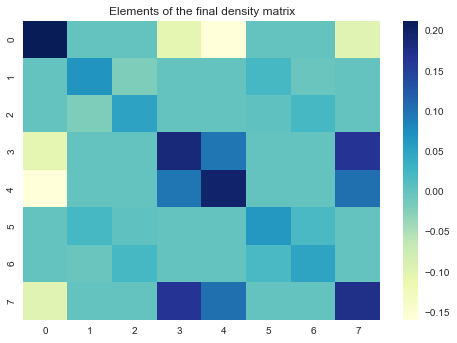

In [87]:
import seaborn
seaborn.heatmap(np.real(rho),cmap="YlGnBu")
plt.title("Elements of the final density matrix")
plt.show()

In [43]:
# for testing purposes the below cells are used

In [41]:
dev = qml.device('default.mixed', wires=2)


@qml.qnode(dev)
def circuit(p):
    qml.BasisState([1,1], wires=[0,1])
    #qml.Hadamard(wires=0)
    #qml.CNOT(wires=[0, 1])
    qml.DepolarizingChannel(p, wires=0)
    qml.DepolarizingChannel(p, wires=1)
    return qml.state()#qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))


circuit(1)

tensor([[0.44444444+0.j, 0.        +0.j, 0.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.22222222+0.j, 0.        +0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j, 0.22222222+0.j, 0.        +0.j],
        [0.        +0.j, 0.        +0.j, 0.        +0.j, 0.11111111+0.j]], requires_grad=True)

In [44]:
red=qi.partial_trace(circuit(1),[1])

In [45]:
red_den=np.array(red)
red_den

tensor([[0.66666667+0.j, 0.        +0.j],
        [0.        +0.j, 0.33333333+0.j]], requires_grad=True)

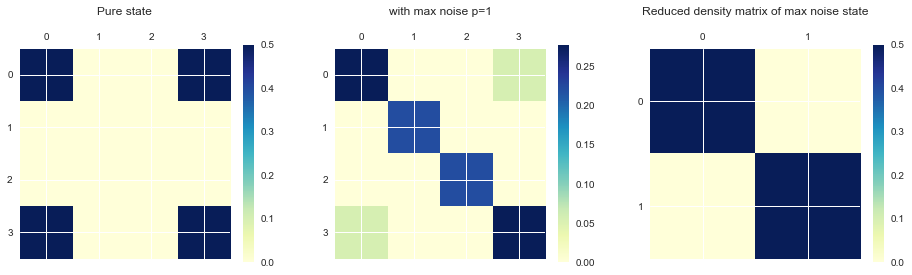

In [52]:
import seaborn
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

ax1, ax2 ,ax3 = axes

im1 = ax1.matshow(np.real(circuit(0)),cmap="YlGnBu")
ax1.set_title("Pure state", y=1.13)

im2 = ax2.matshow(np.real(circuit(1)),cmap="YlGnBu")
ax2.set_title("with max noise p=1", y=1.13)

im3 = ax3.matshow(np.real(red_den),cmap="YlGnBu")
ax3.set_title("Reduced density matrix of max noise state", y=1.13)


fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)